In [1]:
from vnstock import Listing, Quote, Company, Finance, Trading, Screener, Vnstock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import seaborn as sns
import sys
import os



c:\Users\HP\Desktop\Project\monte_carlo_simulation\.venv\Lib\site-packages\vnai\scope\profile.py:742: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Add project root to Python path to enable importing modules from project directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

# Import simulation module for later use in analysis
import modules.simulation as slt
import modules.data_loader as ld
import modules.visualization as vlz
import backtest.backtest as bt

In [3]:
# Get stock data for ACB from VCI source
stock = Vnstock().stock(symbol='ACB', source='VCI')

# Get list of all stocks grouped by their industries
stock_name = stock.listing.symbols_by_industries()

# Display the resulting DataFrame containing stock symbols and their industry classifications
stock_name

,symbol,organ_name,icb_name3,icb_name2,icb_name4,com_type_code,icb_code1,icb_code2,icb_code3,icb_code4
0,ALT,Công ty Cổ phần Văn hóa Tân Bình,Truyền thông,Truyền thông,"Sách, ấn bản & sản phẩm văn hóa",CT,5000,5500,5550,5557
1,APC,Công ty Cổ phần Chiếu xạ An Phú,Dược phẩm,Y tế,Công nghệ sinh học,CT,4000,4500,4570,4573
2,APH,Công ty Cổ phần Tập đoàn An Phát Holdings,Hàng công nghiệp,Hàng & Dịch vụ Công nghiệp,Containers & Đóng gói,CT,2000,2700,2720,2723
3,ASG,Công ty Cổ phần Tập đoàn ASG,Vận tải,Hàng & Dịch vụ Công nghiệp,"Kho bãi, hậu cần và bảo dưỡng",CT,2000,2700,2770,2777
4,CC1,Tổng Công ty Xây dựng số 1 - CTCP,Xây dựng và Vật liệu,Xây dựng và Vật liệu,Xây dựng,CT,2000,2300,2350,2357
...,...,...,...,...,...,...,...,...,...,...
1588,VXP,Công ty Cổ phần Thuốc Thú y Trung ương VETVACO,Hóa chất,Hóa chất,"Sản phẩm hóa dầu, Nông dược & Hóa chất khác",CT,1000,1300,1350,1357
1589,X26,Công ty Cổ phần 26,Hàng cá nhân,Hàng cá nhân & Gia dụng,Hàng May mặc,CT,3000,3700,3760,3763
1590,X77,Công ty Cổ phần Thành An 77,Xây dựng và Vật liệu,Xây dựng và Vật liệu,Vật liệu xây dựng & Nội thất,CT,2000,2300,2350,2353
1591,CQT,Công ty Cổ phần Xi măng Quán Triều VVMI,Xây dựng và Vật liệu,Xây dựng và Vật liệu,Vật liệu xây dựng & Nội thất,CT,2000,2300,2350,2353


In [4]:
stock_name = ld.rename_stock_columns(stock_name)

In [5]:
# Get unique industry names from the stock listing data, excluding any null values
unique_industry = stock_name['industry'].dropna().unique()
unique_industry

array(['Truyền thông', 'Dược phẩm', 'Hàng công nghiệp', 'Vận tải',
       'Xây dựng và Vật liệu', 'Hóa chất', 'Sản xuất thực phẩm',
       'Bia và đồ uống', 'Tư vấn & Hỗ trợ Kinh doanh',
       'Phân phối thực phẩm & dược phẩm', 'Ngân hàng',
       'Dịch vụ tài chính', 'Bất động sản', 'Hàng gia dụng',
       'Công nghiệp nặng', 'Bán lẻ', 'Phần mềm & Dịch vụ Máy tính',
       'Nước & Khí đốt', 'Sản xuất & Phân phối Điện', 'Khai khoáng',
       'Du lịch & Giải trí', 'Hàng cá nhân', 'Thiết bị và Phần cứng',
       'Lâm nghiệp và Giấy', 'Thiết bị và Dịch vụ Y tế',
       'Ô tô và phụ tùng', 'Điện tử & Thiết bị điện', 'Kim loại',
       'Bảo hiểm phi nhân thọ', 'Sản xuất Dầu khí', 'Bảo hiểm nhân thọ',
       'Thiết bị, Dịch vụ và Phân phối Dầu khí', 'Hàng hóa giải trí',
       'Thuốc lá', 'Viễn thông di động', 'Viễn thông cố định'],
      dtype=object)

In [6]:
ld.print_symbols_by_industry(stock_name)

Bia và đồ uống: CPA, BHN, BHP, FGL, BHG, HNR, BSP, HAT, HAV, BHK, BSD, CFV, HKT, BHH, EPC, CTP, BBM, HAD, IFS, HLB, HBH, PCF, BQB, QHW, BSQ, SCD, NAF, BSH, SKH, SAB, SKV, BSL, SBL, SBB, BTB, SKN, SMB, THB, TAN, VCF, SB1, VDL, WSB, VTL
Bán lẻ: CEN, FRT, CPH, CMV, KGM, BTT, COM, HFX, MWG, HTM, PET, PIT, HTT, DKC, DGW, PSD, SAS, SBV, AST, THS, TOP, TV6
Bảo hiểm nhân thọ: BVH
Bảo hiểm phi nhân thọ: ABI, BHI, BLI, BMI, BIC, MIG, PRE, PVI, PTI, PGI, AIC, VNR
Bất động sản: LEC, DXS, HDC, TCH, HPI, FIR, DCH, BCM, HRB, CK8, HTN, HU6, HD8, CKG, AAV, IDC, CEO, IDV, AMD, BSC, CCL, KAC, KBC, KHG, DXG, KOS, CRE, PRT, SSH, LSG, LGL, LHG, BIG, HDG, CLG, MA1, XDH, MBT, HPX, API, NBB, FDC, MGR, C21, NDN, NRC, DRH, NVL, HAR, BII, NTB, NTC, NTL, FLC, AGG, NVT, D11, PDR, EFI, D2D, MH3, HLD, PIV, BVL, PLA, PPI, HQC, KDH, ITC, DTA, LDG, IJC, DIG, IDJ, HD6, ITA, KSF, PTL, LMH, PV2, DTD, HD2, PVL, PWA, QCG, RCL, TBR, PXA, PXL, SJS, SZG, VHM, NLG, PXC, PVR, SID, SGR, VC3, SCR, SIP, SZC, TEG, STL, TID, TAL, SZB,

In [7]:
# Filter DataFrame to get stocks in the Oil & Gas Equipment & Services industry
oil_and_gas_stocks = stock_name[stock_name['industry'] == "Thiết bị, Dịch vụ và Phân phối Dầu khí"]

# Extract the list of stock symbols
oil_and_gas_symbols = oil_and_gas_stocks['stock_symbol'].tolist()

# Display the list of stock symbols
print("Stocks in Oil & Gas Equipment & Services industry:")
oil_and_gas_symbols

Stocks in Oil & Gas Equipment & Services industry:


['TOS', 'PTV', 'PEQ', 'POS', 'PVD', 'PVB', 'PVE', 'PVS', 'PVC']

In [8]:
df= ld.get_stock_data(oil_and_gas_symbols,  "2025-01-01", "2025-05-10")

Saved data for TOS to ../data/TOS.csv
Saved data for PTV to ../data/PTV.csv
Saved data for PEQ to ../data/PEQ.csv
Saved data for POS to ../data/POS.csv
Saved data for PVD to ../data/PVD.csv
Saved data for PVB to ../data/PVB.csv
Saved data for PVE to ../data/PVE.csv
Saved data for PVS to ../data/PVS.csv
Saved data for PVC to ../data/PVC.csv



Analyzing TOS...


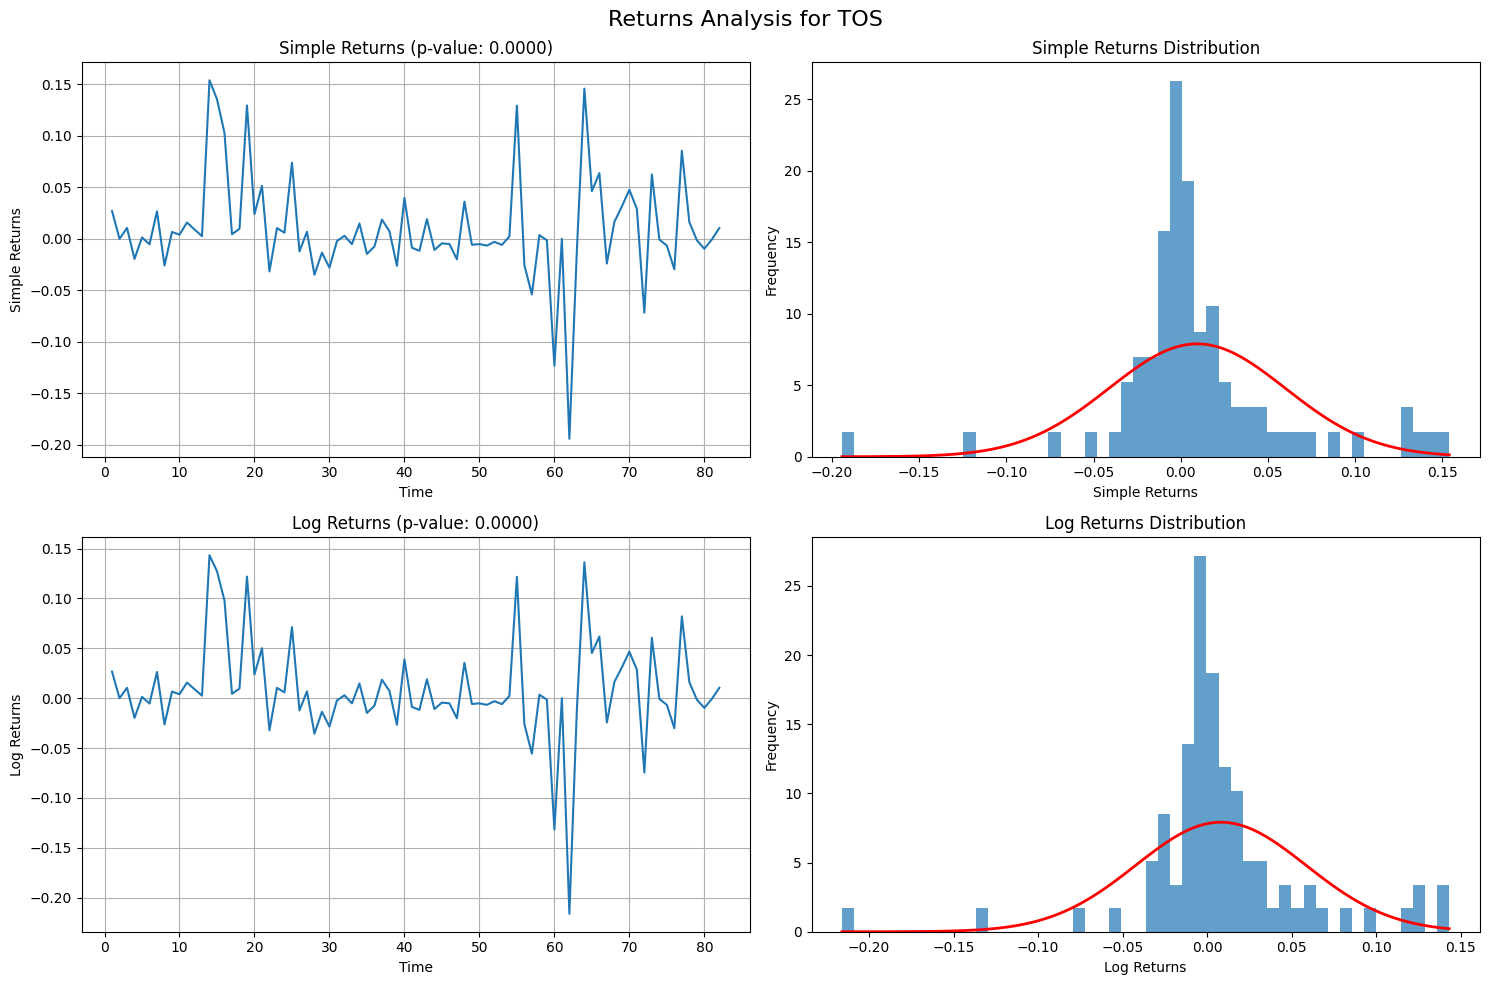

Simple returns ADF test p-value: 0.0000
Log returns ADF test p-value: 0.0000

Interpretation:
p-value < 0.05 indicates stationarity
p-value >= 0.05 indicates non-stationarity

Analyzing PTV...


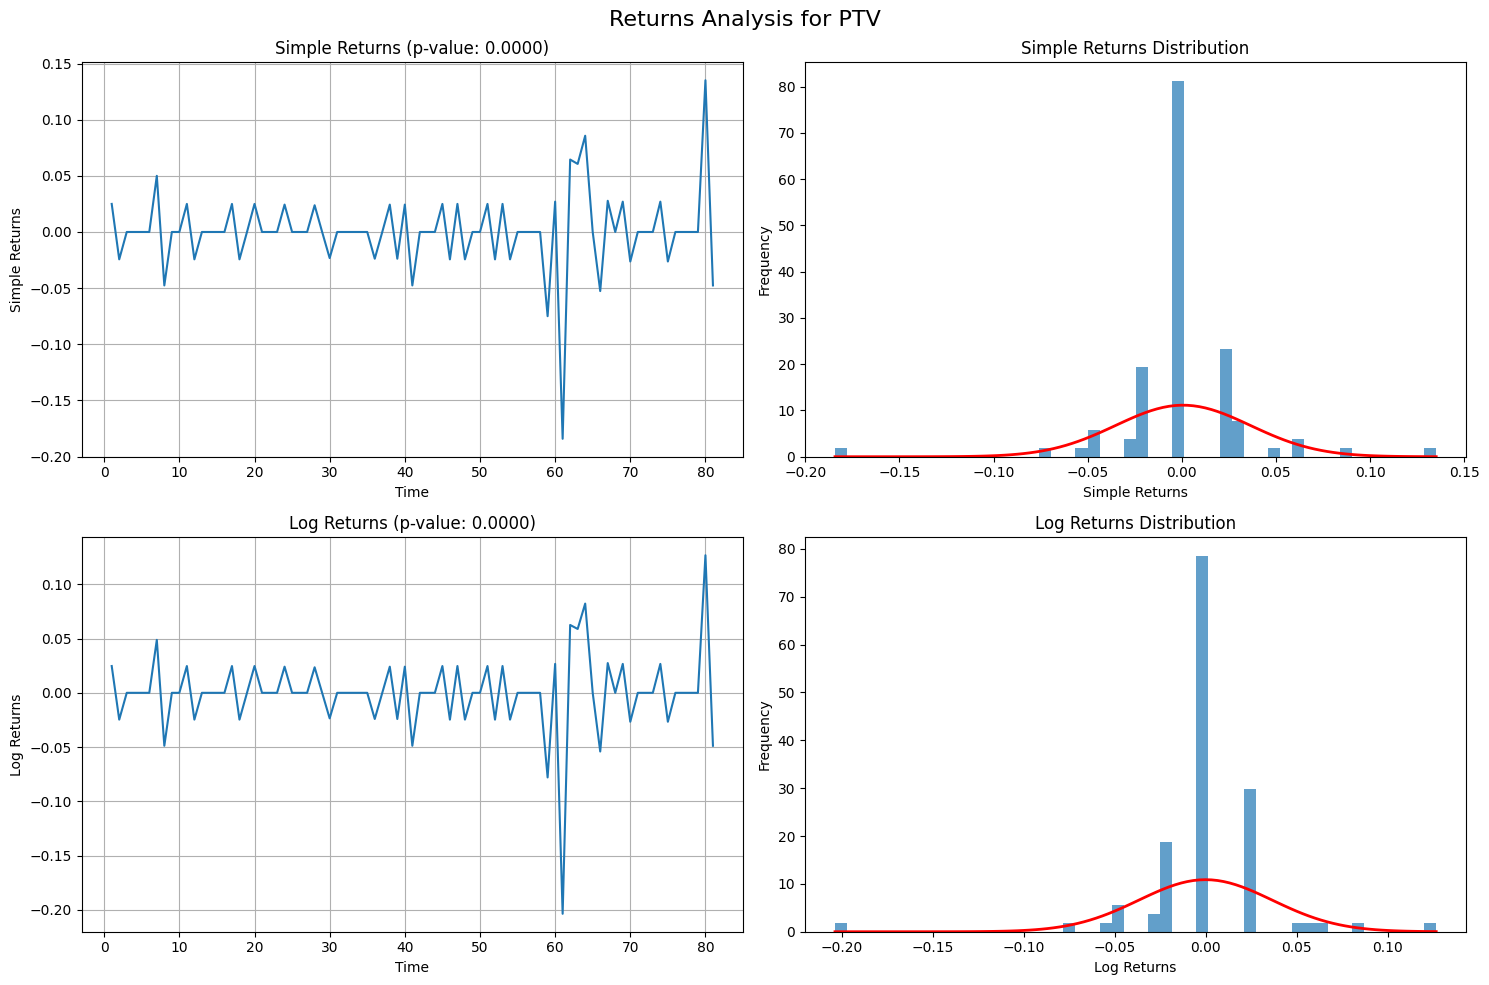

Simple returns ADF test p-value: 0.0000
Log returns ADF test p-value: 0.0000

Interpretation:
p-value < 0.05 indicates stationarity
p-value >= 0.05 indicates non-stationarity

Analyzing PEQ...


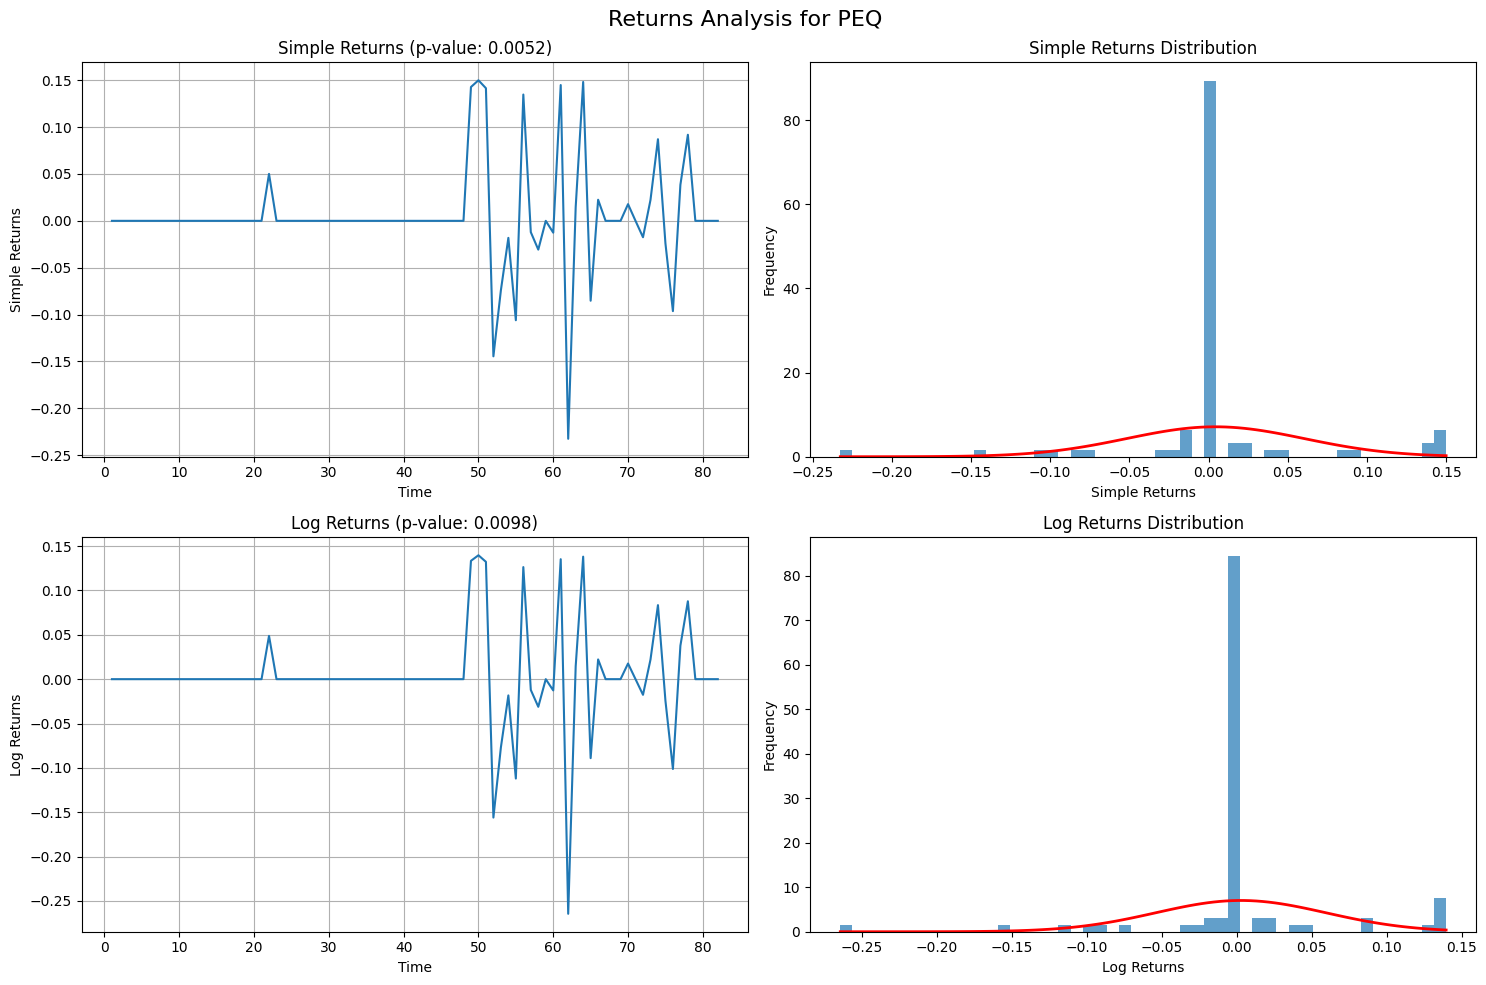

Simple returns ADF test p-value: 0.0052
Log returns ADF test p-value: 0.0098

Interpretation:
p-value < 0.05 indicates stationarity
p-value >= 0.05 indicates non-stationarity

Analyzing POS...


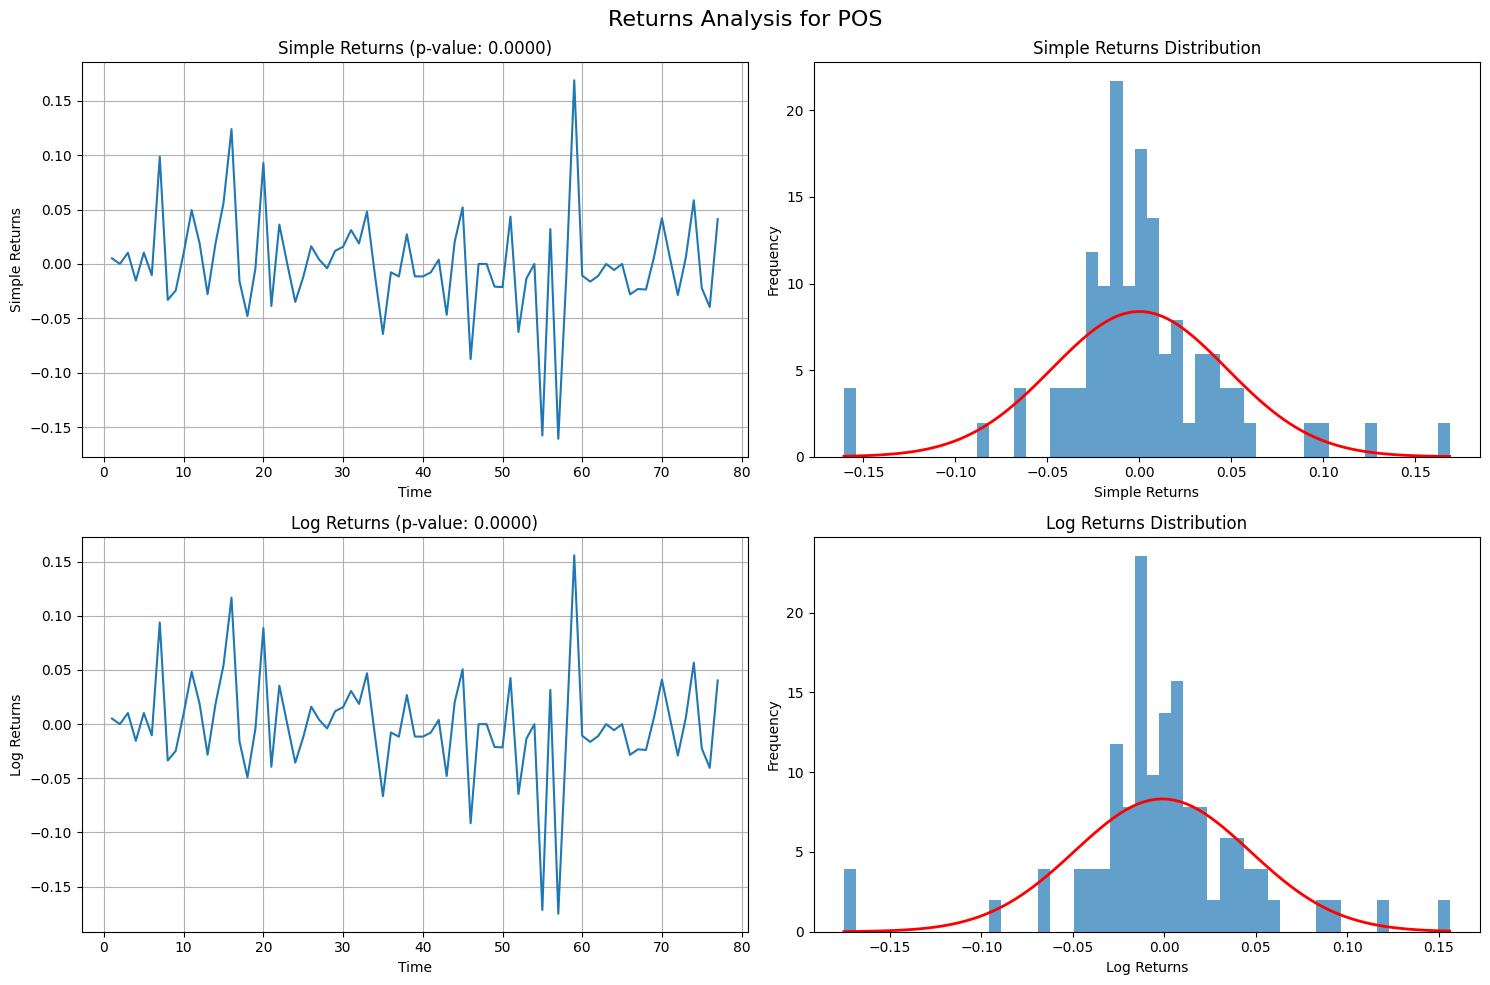

Simple returns ADF test p-value: 0.0000
Log returns ADF test p-value: 0.0000

Interpretation:
p-value < 0.05 indicates stationarity
p-value >= 0.05 indicates non-stationarity

Analyzing PVD...


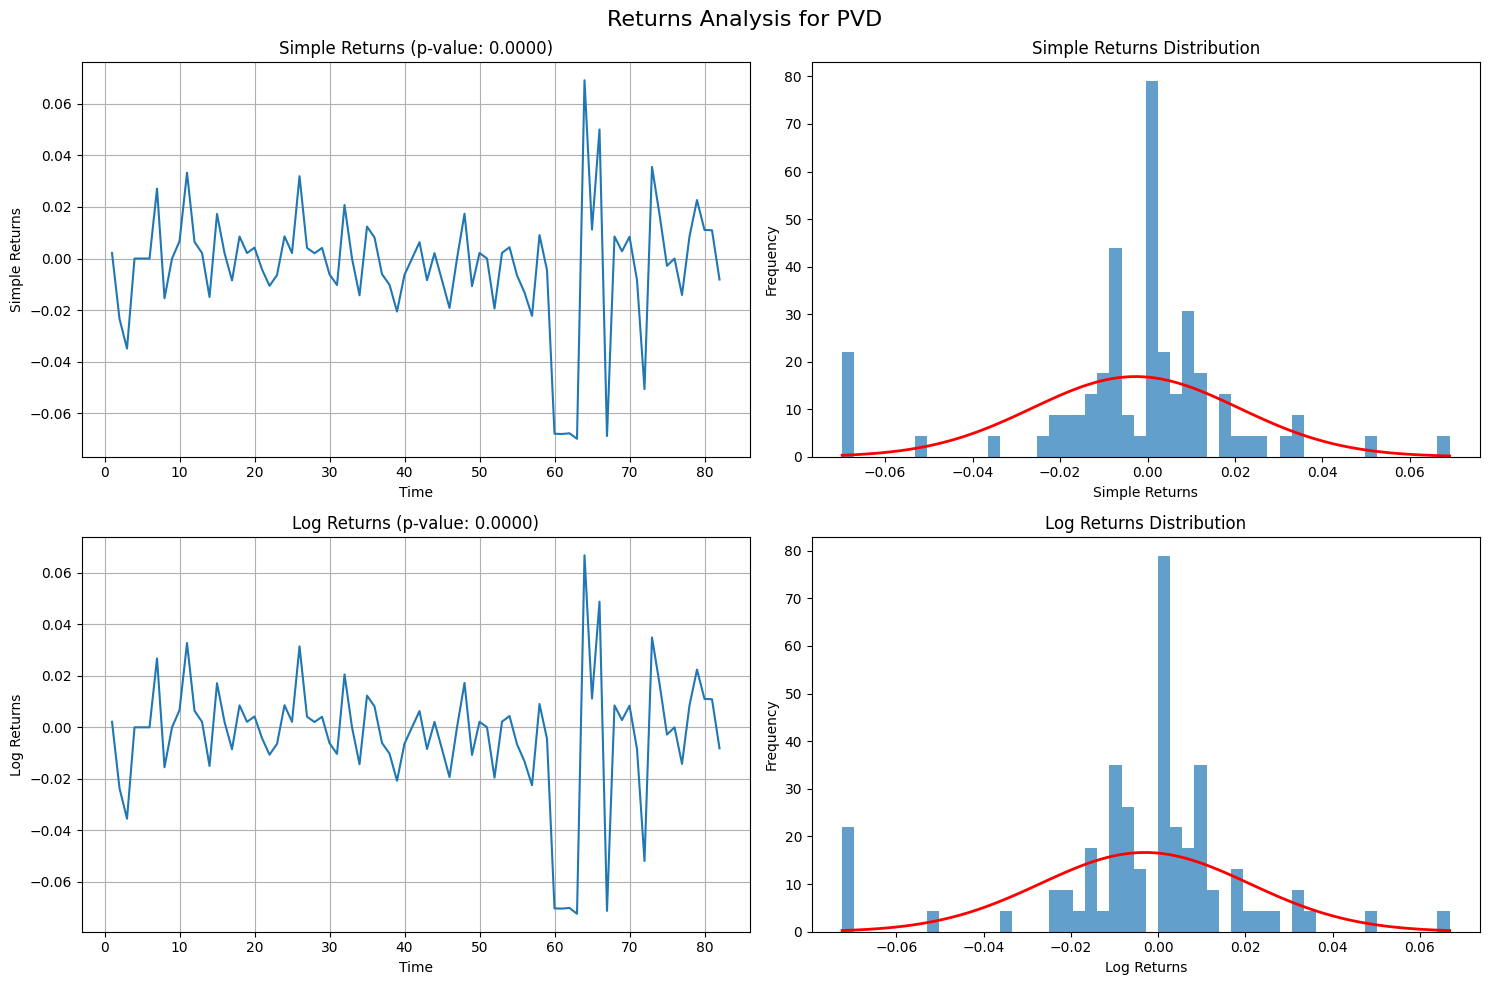

Simple returns ADF test p-value: 0.0000
Log returns ADF test p-value: 0.0000

Interpretation:
p-value < 0.05 indicates stationarity
p-value >= 0.05 indicates non-stationarity

Analyzing PVB...


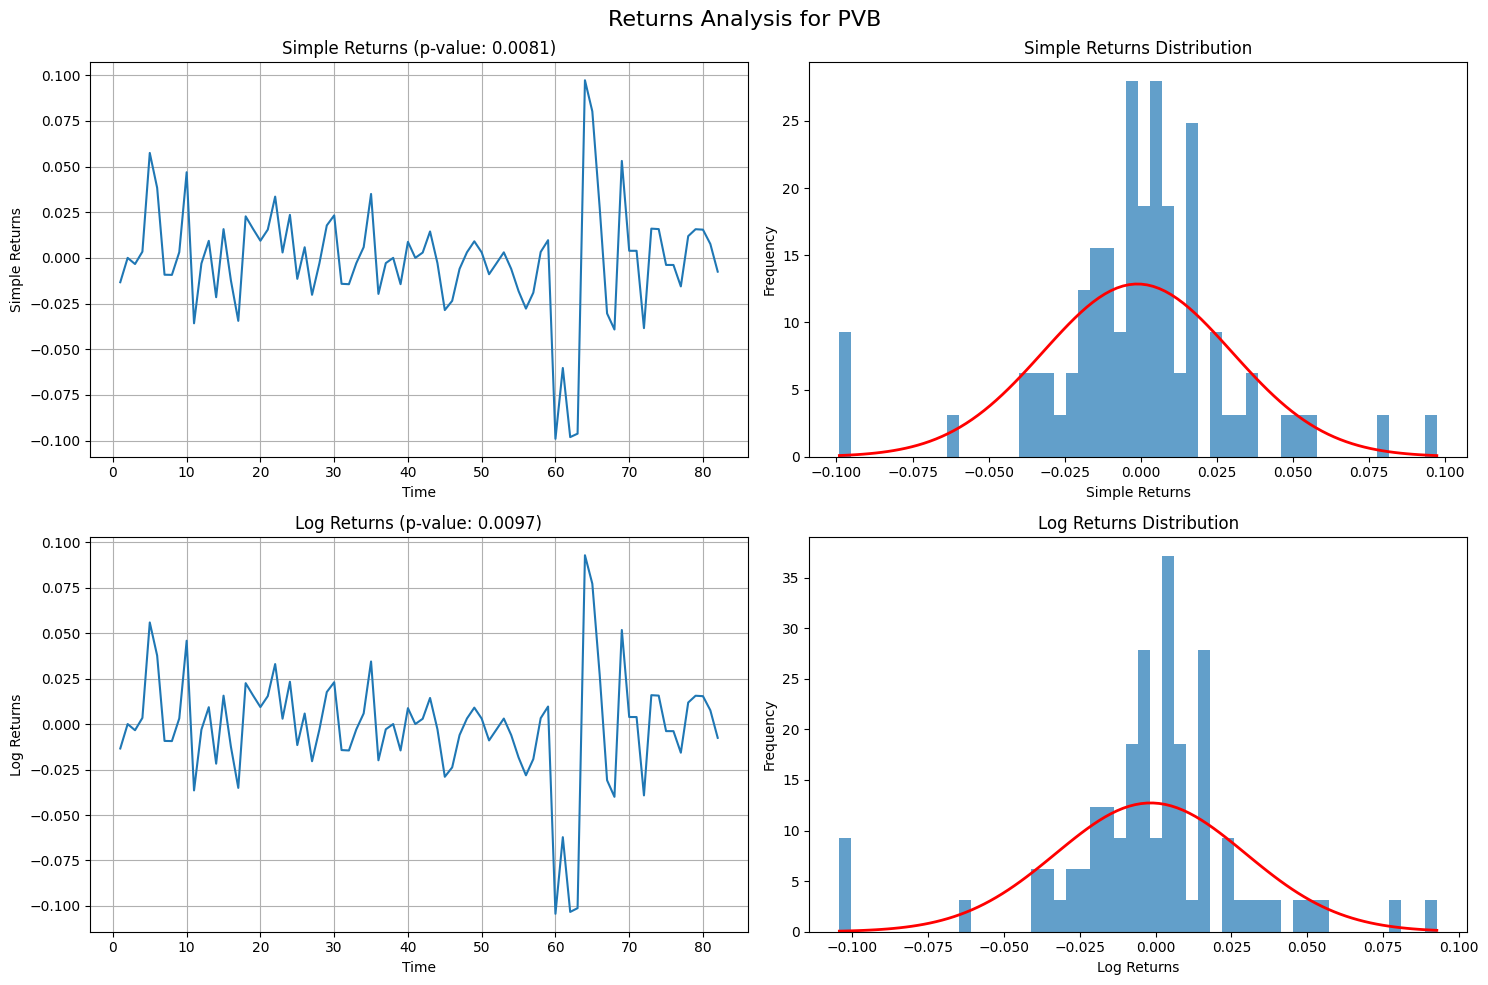

Simple returns ADF test p-value: 0.0081
Log returns ADF test p-value: 0.0097

Interpretation:
p-value < 0.05 indicates stationarity
p-value >= 0.05 indicates non-stationarity

Analyzing PVE...


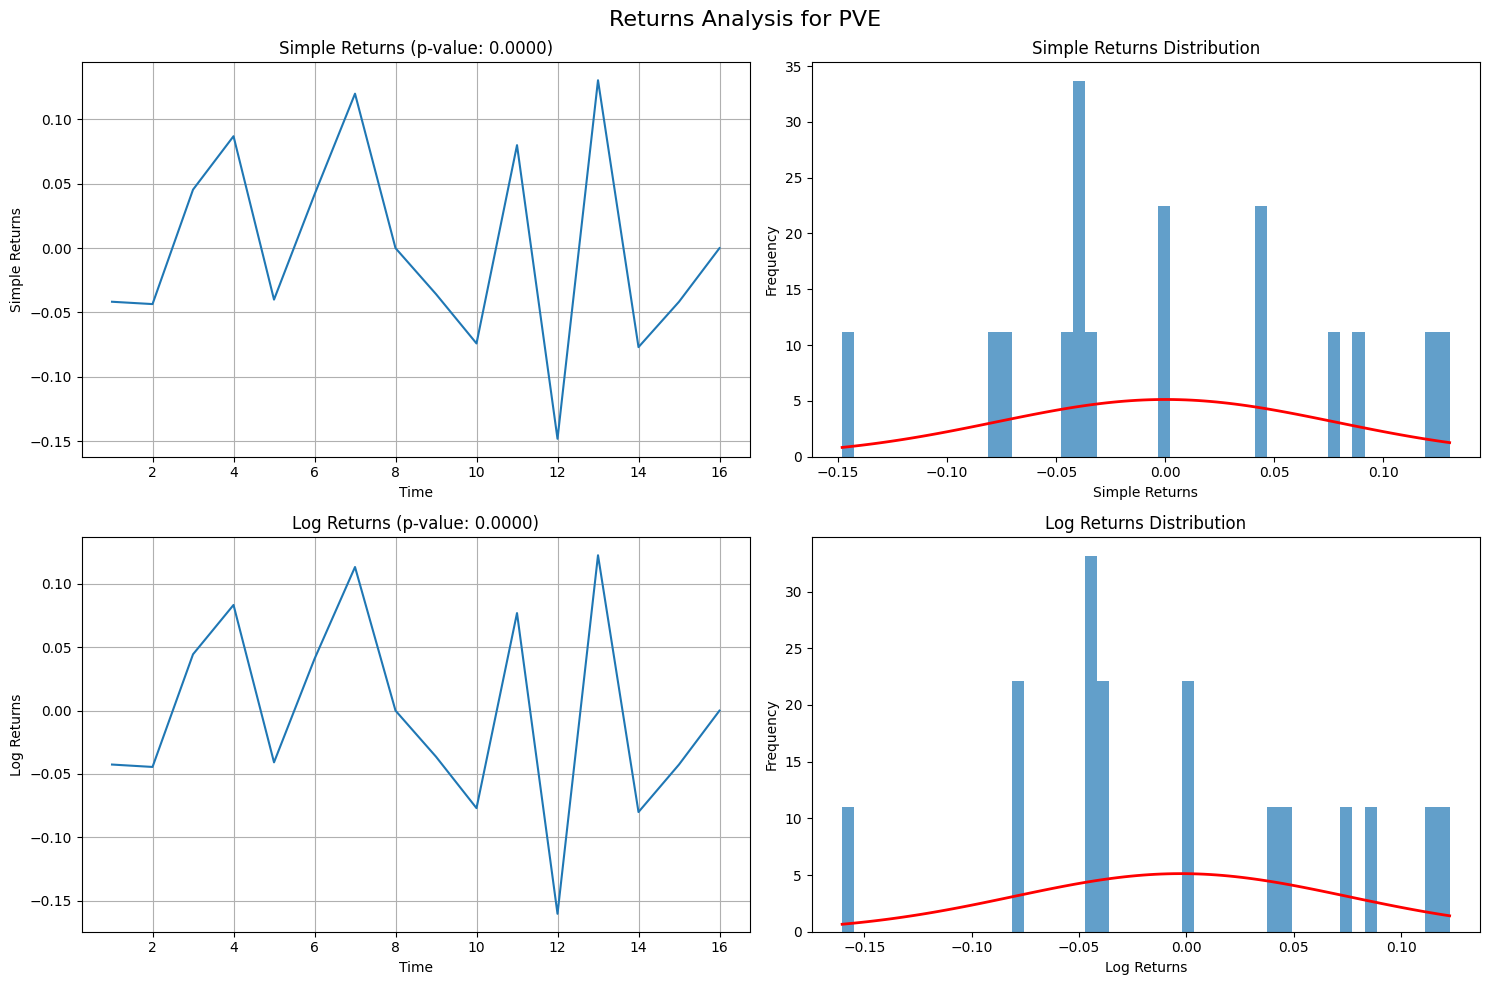

Simple returns ADF test p-value: 0.0000
Log returns ADF test p-value: 0.0000

Interpretation:
p-value < 0.05 indicates stationarity
p-value >= 0.05 indicates non-stationarity

Analyzing PVS...


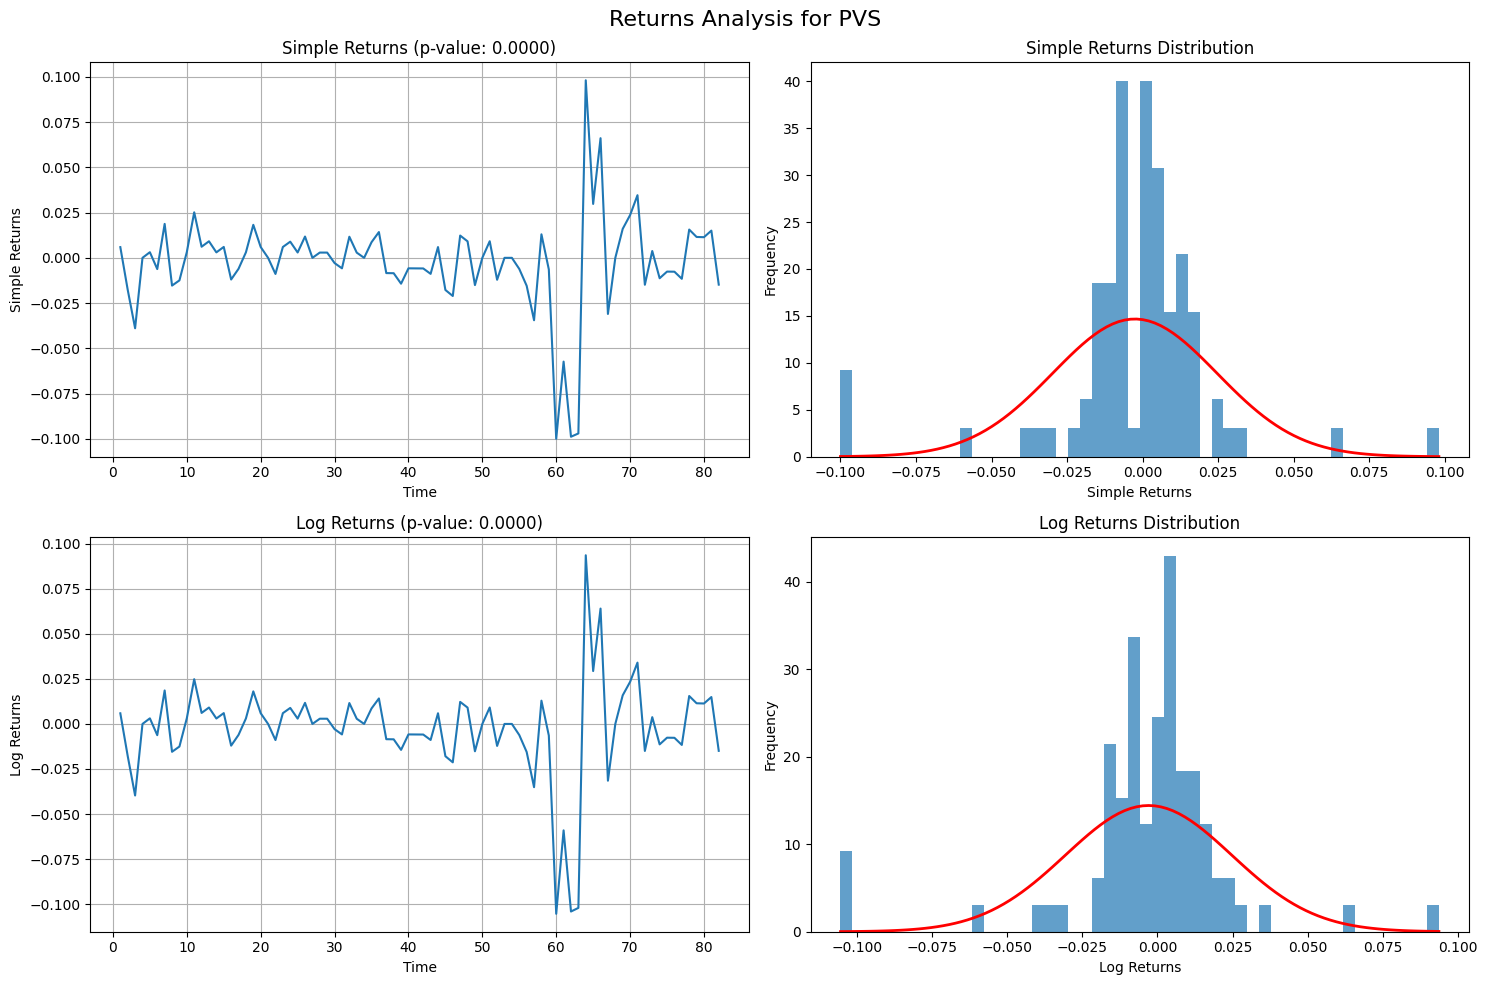

Simple returns ADF test p-value: 0.0000
Log returns ADF test p-value: 0.0000

Interpretation:
p-value < 0.05 indicates stationarity
p-value >= 0.05 indicates non-stationarity

Analyzing PVC...


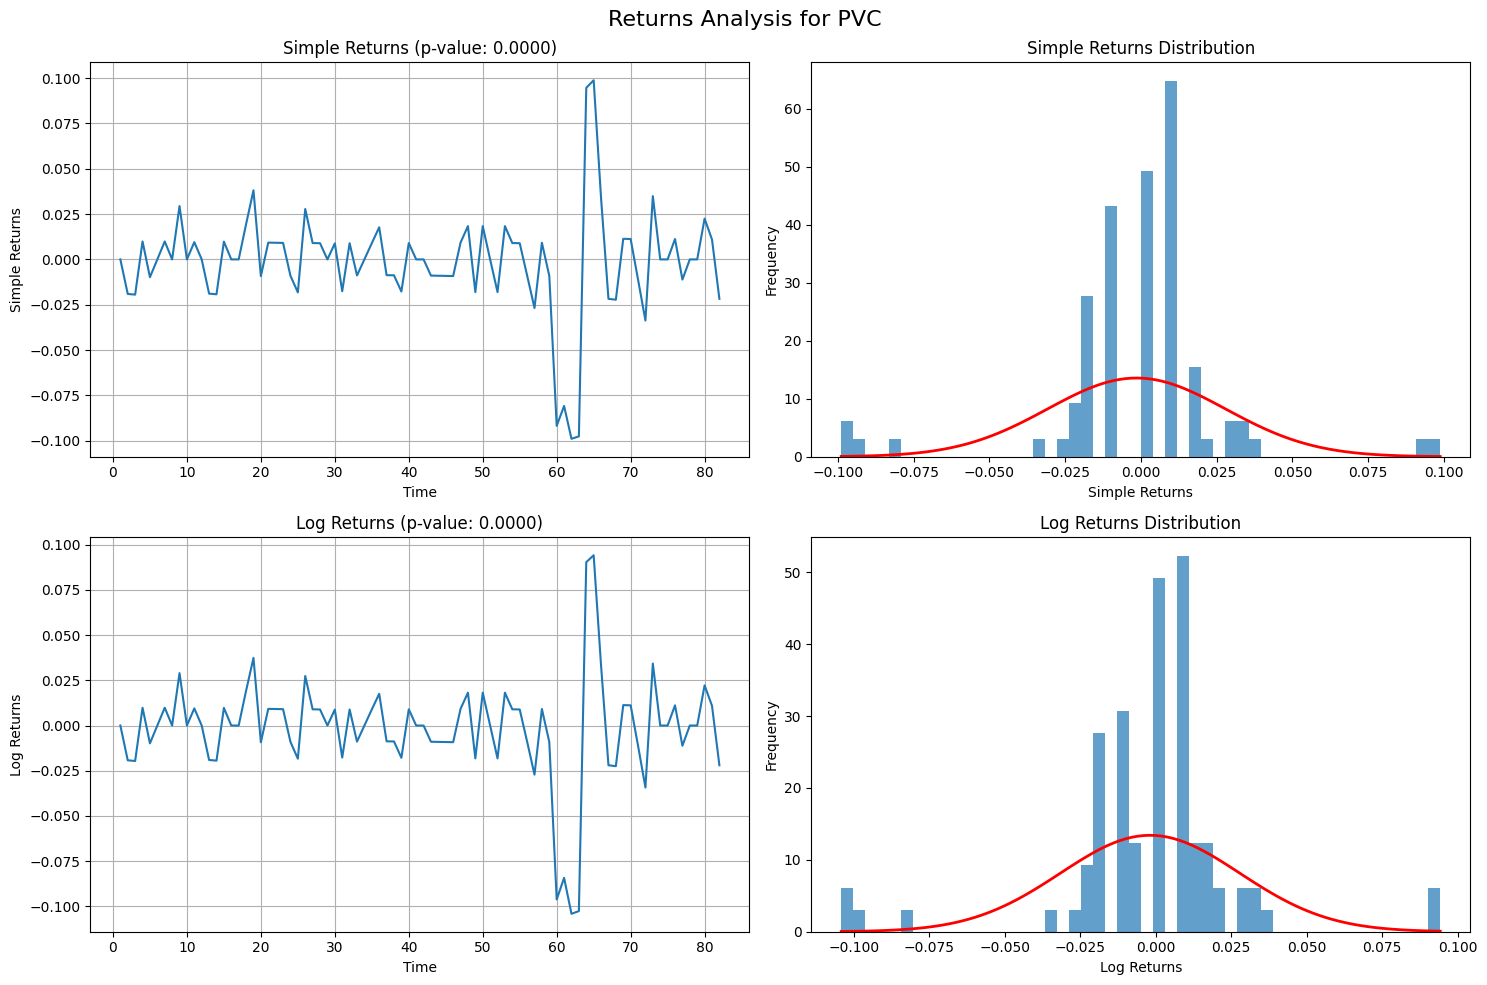

Simple returns ADF test p-value: 0.0000
Log returns ADF test p-value: 0.0000

Interpretation:
p-value < 0.05 indicates stationarity
p-value >= 0.05 indicates non-stationarity


In [9]:
returns= vlz.analyze_stock_returns(df)

In [10]:
adf = bt.adf_test(returns)


Analyzing TOS...

Augmented Dickey-Fuller Test Results:
Test Statistic: -7.7485
p-value: 0.0000
Stationary: Yes

Analyzing PTV...

Augmented Dickey-Fuller Test Results:
Test Statistic: -6.1112
p-value: 0.0000
Stationary: Yes

Analyzing PEQ...

Augmented Dickey-Fuller Test Results:
Test Statistic: -3.4365
p-value: 0.0098
Stationary: Yes

Analyzing POS...

Augmented Dickey-Fuller Test Results:
Test Statistic: -9.5791
p-value: 0.0000
Stationary: Yes

Analyzing PVD...

Augmented Dickey-Fuller Test Results:
Test Statistic: -5.7910
p-value: 0.0000
Stationary: Yes

Analyzing PVB...

Augmented Dickey-Fuller Test Results:
Test Statistic: -3.4403
p-value: 0.0097
Stationary: Yes

Analyzing PVE...

Augmented Dickey-Fuller Test Results:
Test Statistic: -5.7198
p-value: 0.0000
Stationary: Yes

Analyzing PVS...

Augmented Dickey-Fuller Test Results:
Test Statistic: -6.5723
p-value: 0.0000
Stationary: Yes

Analyzing PVC...

Augmented Dickey-Fuller Test Results:
Test Statistic: -6.1640
p-value: 0.0000

In [11]:
ds = bt.describe_statistics(returns)


📊 Analyzing TOS:
Mean: 0.008144
Standard Deviation: 0.050389
Skewness: -0.4187
Kurtosis: 5.6759

📊 Analyzing PTV:
Mean: -0.000000
Standard Deviation: 0.036681
Skewness: -1.6087
Kurtosis: 12.7262

📊 Analyzing PEQ:
Mean: 0.002721
Standard Deviation: 0.056778
Skewness: -0.8377
Kurtosis: 7.1857

📊 Analyzing POS:
Mean: -0.001124
Standard Deviation: 0.047940
Skewness: -0.4637
Kurtosis: 4.6549

📊 Analyzing PVD:
Mean: -0.003024
Standard Deviation: 0.023977
Skewness: -0.9417
Kurtosis: 3.0015

📊 Analyzing PVB:
Mean: -0.001605
Standard Deviation: 0.031339
Skewness: -0.6594
Kurtosis: 3.6322

📊 Analyzing PVE:
Mean: -0.002660
Standard Deviation: 0.077849
Skewness: -0.0377
Kurtosis: -0.3810

📊 Analyzing PVS:
Mean: -0.002921
Standard Deviation: 0.027671
Skewness: -1.1931
Kurtosis: 6.8115

📊 Analyzing PVC:
Mean: -0.001880
Standard Deviation: 0.029731
Skewness: -0.7950
Kurtosis: 5.5122


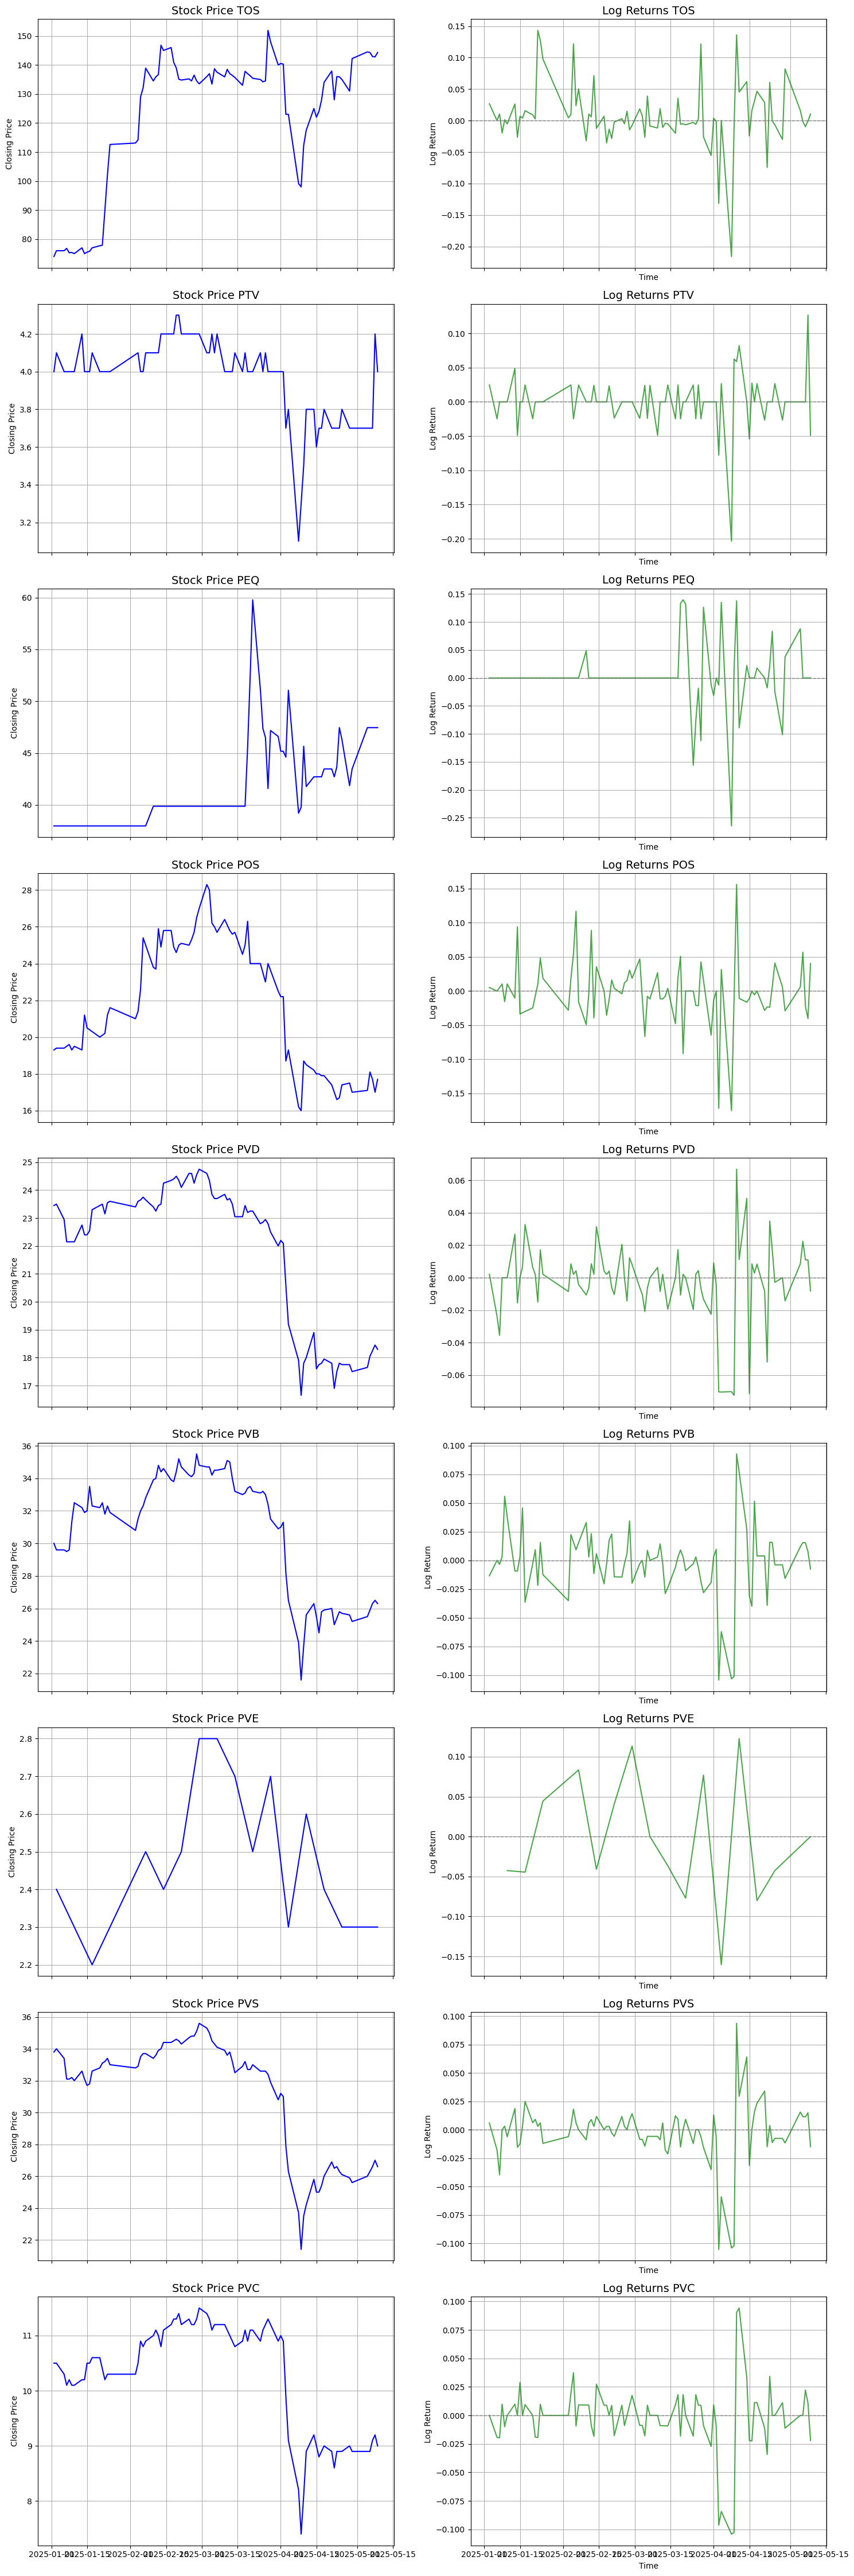

In [12]:
# Visualization and log_return
vlz.visualize_price_and_returns(df)

In [13]:
# Run Monte Carlo simulation for 30 days with 100,000 simulations per stock
compare_df = slt.monte_carlo_compare(data_dict=df, days=30, simulations=100000)

# Display results sorted by expected return
print("\nMonte Carlo Simulation Results (30-day horizon):")
print("===============================================")
print(compare_df.to_string(index=False))



Monte Carlo Simulation Results (30-day horizon):
Symbol  Expected Return  Risk (Std Dev)     VaR 5%  Current Price
   TOS        32.447555       37.300593 -19.127864         144.30
   PEQ        13.823854       36.313146 -34.992315          47.45
   PTV         2.017033       20.752749 -28.108514           4.00
   PVE         1.100201       44.985961 -54.189669           2.30
   POS         0.117658       26.733373 -37.033328          17.70
   PVB        -3.254599       16.721145 -28.078981          26.30
   PVC        -4.322591       15.634340 -27.571726           9.00
   PVS        -7.356503       14.106215 -28.636425          26.60
   PVD        -7.931723       12.125618 -26.363127          18.30


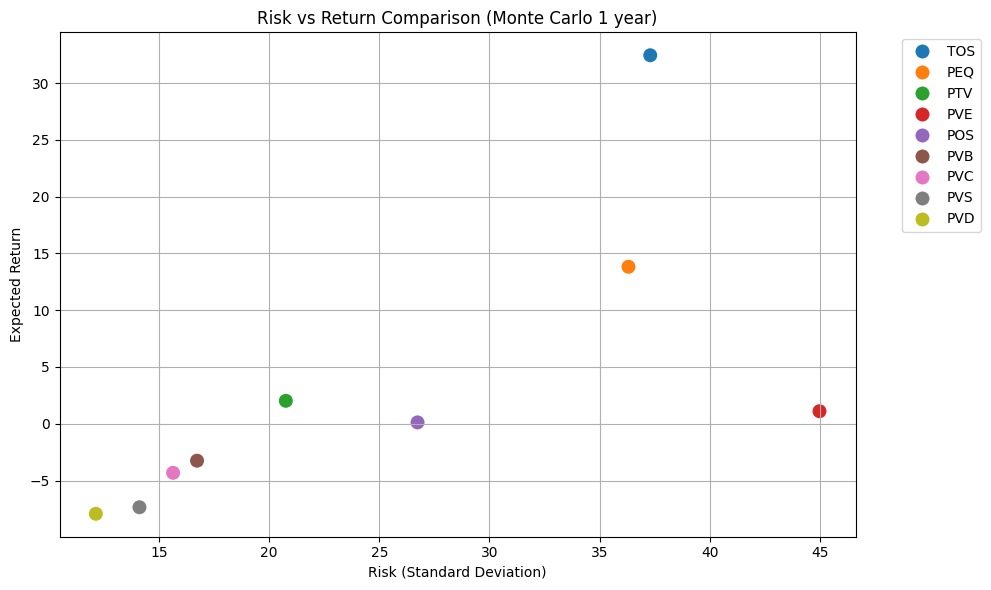

In [14]:
vlz.plot_risk_return(compare_df)

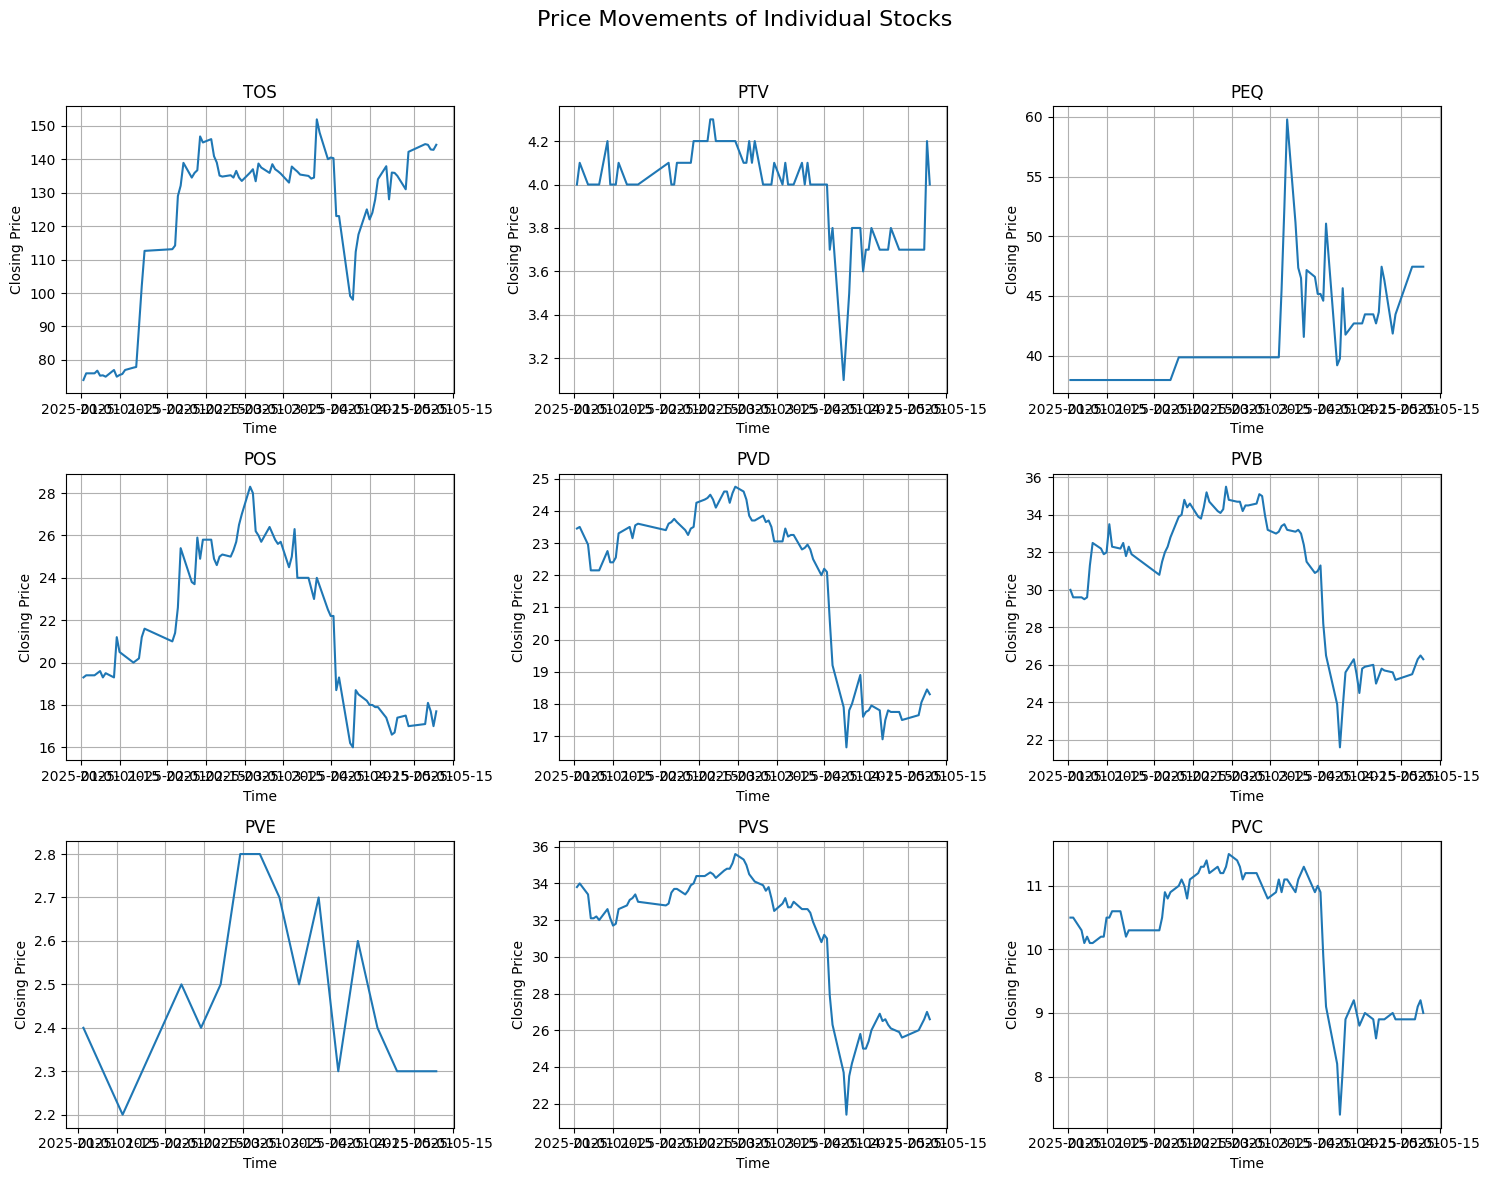

In [15]:
vlz.plot_individual_stocks(df, cols = 3)
